In [ ]:
from impy import models as im
from impy.kinematics import CenterOfMass, GeV, TeV
from impy.remote_control import MCRunRemote
from impy.constants import GeV
from impy.util import get_all_models
from particle import literals as lp
import numpy as np
import joblib

In [ ]:
energies = np.geomspace(10 * GeV, 100 * TeV, 20)


@joblib.delayed
def run(Model):
    values = []
    # disable remote control, since this breaks joblib
    m = Model(seed=1, timeout=0)
    for en in energies:
        kin = CenterOfMass(en, "p", "p")
        c = m.cross_section(kin)
        values.append(c)
    return values


Models = [M for M in get_all_models() if lp.proton.pdgid in M.projectiles]
# Comment this to also run Pythia8, which takes several minutes
Models.remove(im.Pythia8)
cross_sections = {}
out = joblib.Parallel(len(Models), batch_size=1)(run(Model) for Model in Models)
for Model, o in zip(Models, out):
    cross_sections[Model.pyname] = o

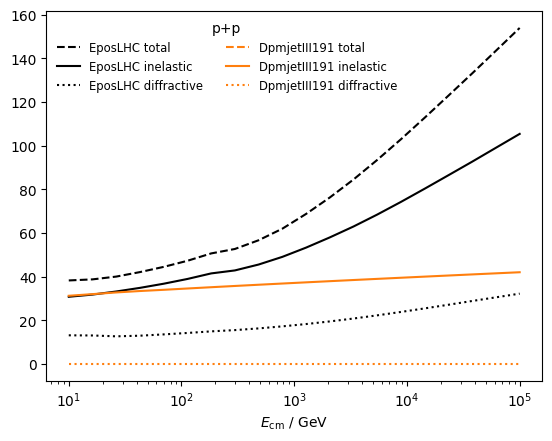

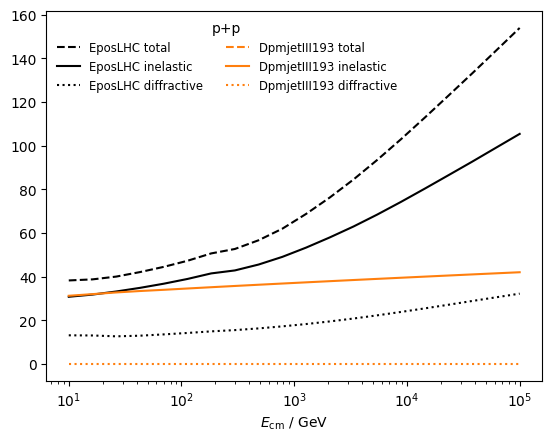

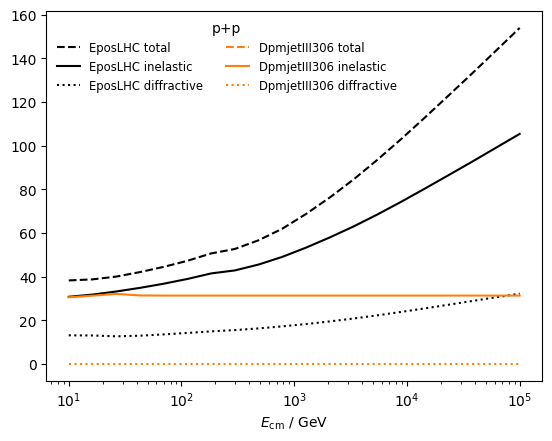

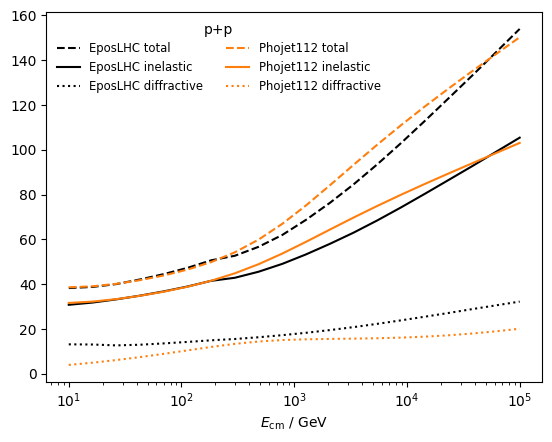

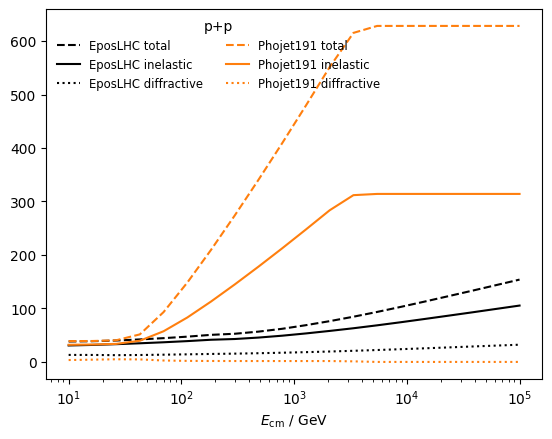

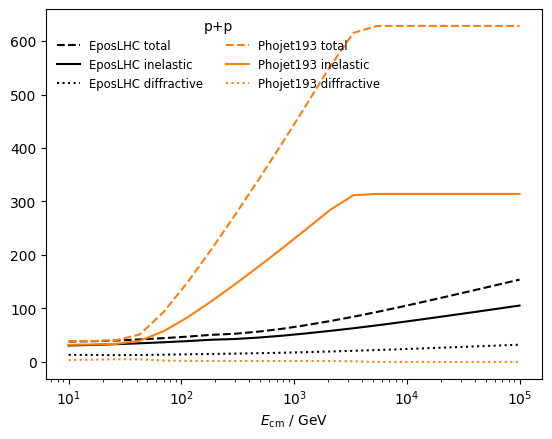

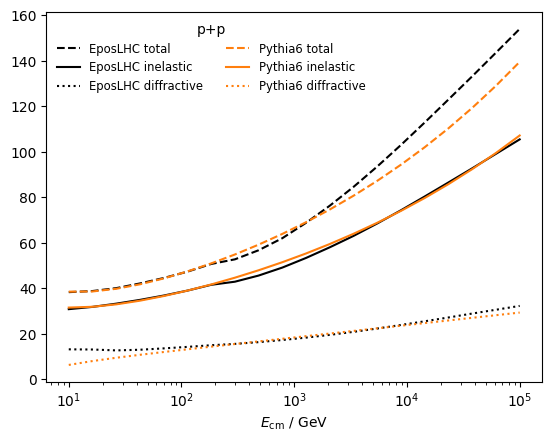

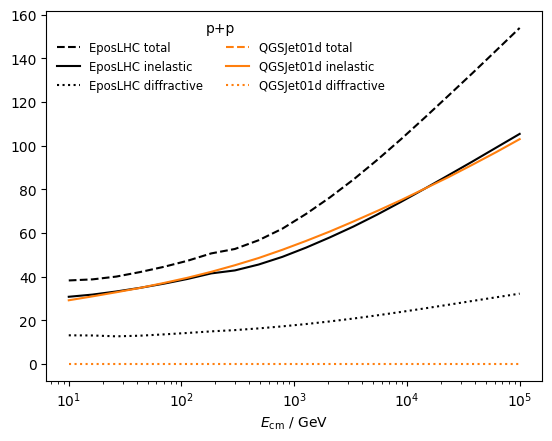

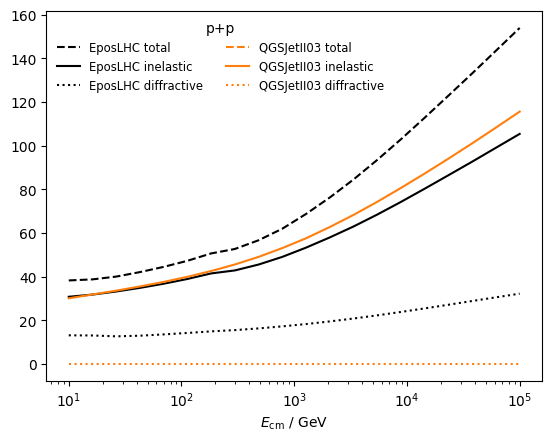

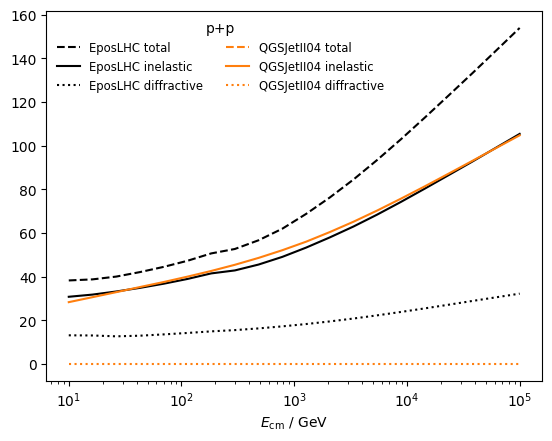

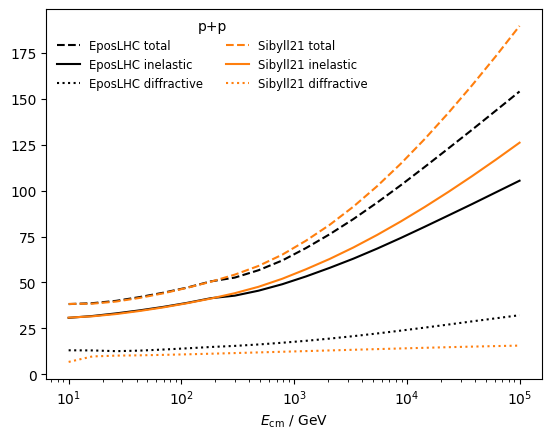

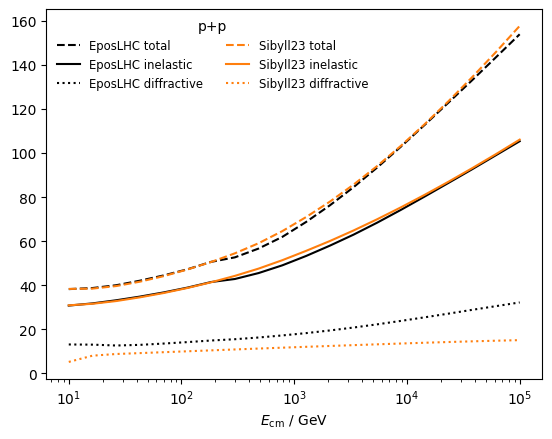

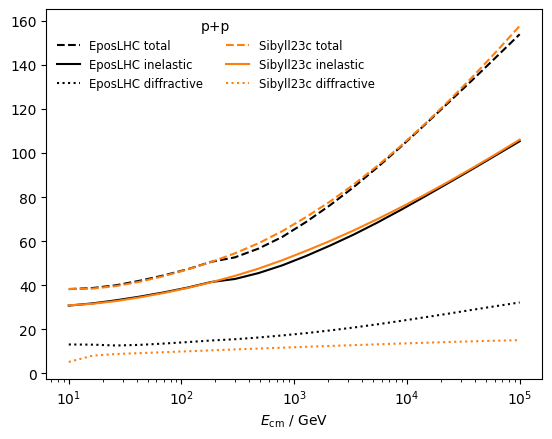

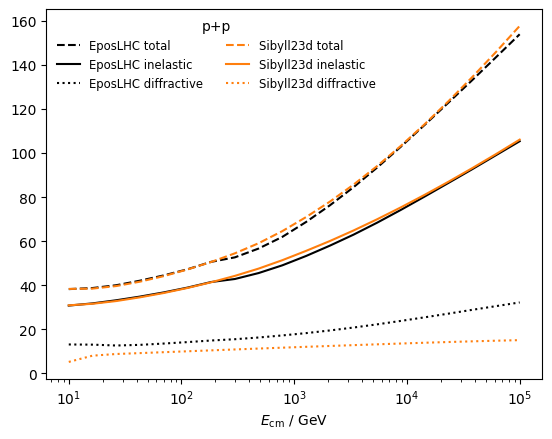

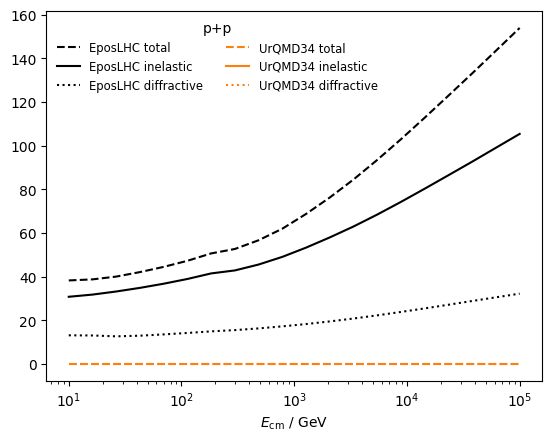

In [7]:
from matplotlib import pyplot as plt
import dataclasses

reference_model = "EposLHC"

for model in cross_sections:
    if model == reference_model:
        continue
    plt.figure()
    kinds = "total", "inelastic", "diffractive"
    for k, model2 in enumerate((reference_model, model)):
        data = cross_sections[model2]
        for i, kind in enumerate(kinds):
            if kind == "diffractive":
                val = [
                    sum(
                        (0 if np.isnan(v) else v)
                        for k, v in dataclasses.asdict(d).items()
                        if "diffractive" in k
                    )
                    for d in data
                ]
            else:
                val = [getattr(d, kind) for d in data]

            if np.any(val != 0):
                plt.plot(
                    energies / GeV,
                    val,
                    label=model2 + " " + kind,
                    ls=["--", "-", ":"][i],
                    color=["k", "C1"][k],
                    zorder=1 + k,
                )
    plt.semilogx()
    plt.legend(frameon=False, ncol=2, fontsize="small", title="p+p")
    plt.xlabel("$E_\\mathrm{cm}$ / GeV")
    